In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import os.path
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import GRU, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import metrics
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
os.chdir('C:\\Users\\anear\\OneDrive - National University of Ireland, Galway\\PhD\\Research Projects\\Ventilation Project')

Using TensorFlow backend.


In [2]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_1 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
__________________________

In [3]:
# Load the data
_data = np.load('res/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_train_norm']
y_train = _data['y_train']
X_val = _data['X_val_norm']
y_val = _data['y_val']
X_test = _data['X_test_norm']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [4]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 9065
No. of patients in train, val, test sets: 7252, 906, 907
No. of extubation failures in train, val, test sets: 2987, 383, 390
Proportion of extubation failures in train, val, test sets: 41.189%, 42.274%, 42.999%


In [5]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [6]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7252, 24, 37)
y_train: (7252,)
X_val: (906, 24, 37)
y_val: (906,)
X_test: (907, 24, 37)
y_test: (907,)


In [7]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])


Train on 7252 samples, validate on 906 samples
Epoch 1/250
7252/7252 [==============================] - 2s 242us/step - loss: 0.6234 - auc_1: 0.6954 - val_loss: 0.6383 - val_auc_1: 0.7521
Epoch 2/250
7252/7252 [==============================] - 1s 141us/step - loss: 0.5767 - auc_1: 0.7380 - val_loss: 0.6050 - val_auc_1: 0.7629
Epoch 3/250
7252/7252 [==============================] - 1s 141us/step - loss: 0.5631 - auc_1: 0.7536 - val_loss: 0.5826 - val_auc_1: 0.7765
Epoch 4/250
7252/7252 [==============================] - 1s 147us/step - loss: 0.5527 - auc_1: 0.7609 - val_loss: 0.5648 - val_auc_1: 0.7793
Epoch 5/250
7252/7252 [==============================] - 1s 141us/step - loss: 0.5435 - auc_1: 0.7710 - val_loss: 0.5495 - val_auc_1: 0.7886
Epoch 6/250
7252/7252 [==============================] - 1s 148us/step - loss: 0.5388 - auc_1: 0.7742 - val_loss: 0.5458 - val_auc_1: 0.7843
Epoch 7/250
7252/7252 [==============================] - 1s 141us/step - loss: 0.5301 - auc_1: 0.7853 - va

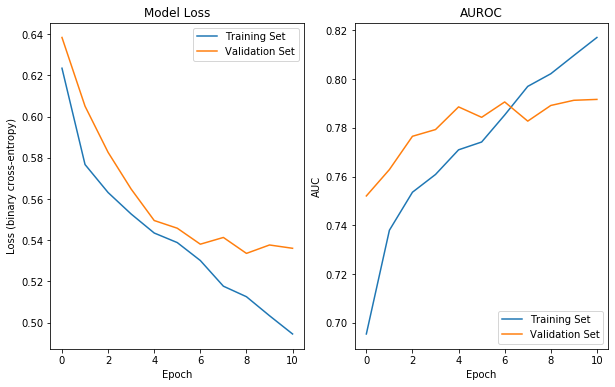

In [8]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_1'])
ax2.plot(history.history['val_auc_1'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [9]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_rnn = model.predict(X_test).ravel()
fpr_rnn, tpr_rnn, thresholds = roc_curve(y_test, y_pred_rnn)

In [10]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_rnn = auc(fpr_rnn, tpr_rnn)

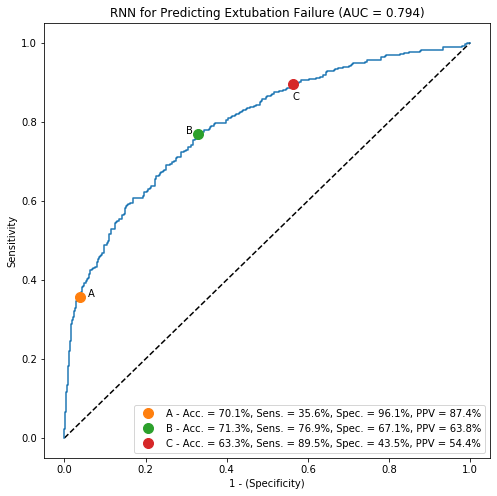

In [11]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.8, 0.35, 0.25
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_test, y_pred_rnn[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_test, y_pred_rnn[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_test, y_pred_rnn[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn)
plt.plot(fpr_rnn[A], tpr_rnn[A],'.', markersize=20, label='A - Acc. = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
plt.annotate('A', (fpr_rnn[A]+0.02, tpr_rnn[A]))
plt.plot(fpr_rnn[B], tpr_rnn[B],'.', markersize=20, label='B - Acc. = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
plt.annotate('B', (fpr_rnn[B]-0.03, tpr_rnn[B]))
plt.plot(fpr_rnn[C], tpr_rnn[C],'.', markersize=20, label='C - Acc. = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
plt.annotate('C', (fpr_rnn[C], tpr_rnn[C]-0.04))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('RNN for Predicting Extubation Failure (AUC = {:.3f})'.format(auc_rnn))
plt.legend(loc='lower right')
plt.savefig('plots/rnn.png', bbox_inches='tight')
plt.show()

In [12]:
# Write a function that plots nice confusion matrices
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm[0][0] = round(cm[0][0],2)
        cm[0][1] = round(cm[0][1],2)
        cm[1][0] = round(cm[1][0],2)
        cm[1][1] = round(cm[1][1],2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

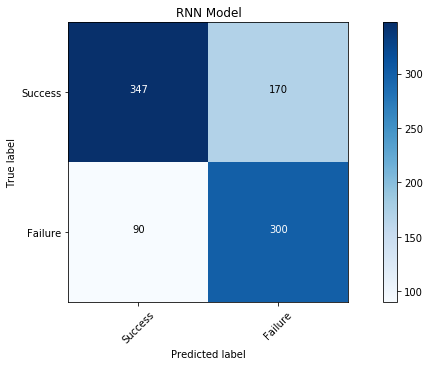

In [13]:
# Calculate the confusion matrix
decision_threshold = thresh_B
cm = confusion_matrix(y_test, y_pred_rnn[:]>decision_threshold)
plot_confusion_matrix(cm, ['Success', 'Failure'], normalize=False, title='RNN Model')

In [14]:
# Load the data
_data = np.load('res/ML_data.npy', allow_pickle=True).tolist()
X_train_raw = _data['X_train']
y_train = _data['y_train']
X_val_raw = _data['X_val']
y_val = _data['y_val']
X_test_raw = _data['X_test']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [15]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 9065
No. of patients in train, val, test sets: 7252, 906, 907
No. of extubation failures in train, val, test sets: 2987, 383, 390
Proportion of extubation failures in train, val, test sets: 41.189%, 42.274%, 42.999%


In [16]:
# Check the shapes of the arrays
print("X_train_raw: {}".format(np.shape(X_train_raw)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val_raw: {}".format(np.shape(X_val_raw)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test_raw: {}".format(np.shape(X_test_raw)))
print("y_test: {}".format(np.shape(y_test)))

X_train_raw: (7252, 37, 24)
y_train: (7252,)
X_val_raw: (906, 37, 24)
y_val: (906,)
X_test_raw: (907, 37, 24)
y_test: (907,)


In [17]:
# Prepare training data for non-temporal models
m, n, T = np.shape(X_train_raw)
X_train_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_train_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_train_static[i,(j*4):(j*4+4)] = extracted_features
        
# Prepare test data for non-temporal models
m, n, T = np.shape(X_test_raw)
X_test_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_test_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_test_static[i,(j*4):(j*4+4)] = extracted_features
        
# Check the shapes of the new arrays
print("X_train_static: {}".format(np.shape(X_train_static)))
print("X_test_static: {}".format(np.shape(X_test_static)))

X_train_static: (7252, 148)
X_test_static: (907, 148)


In [18]:
# Scale the training data using a z-transform, and apply that scaler to the test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_static)
X_test_scaled = scaler.transform(X_test_static)
print(np.shape(X_train_scaled))

(7252, 148)


In [19]:
# Create logistic regression classifer object
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred_lr = logisticRegr.predict_proba(X_test_scaled)[:,1]

In [20]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)

In [21]:
# Calculate the AUROC for the test set
from sklearn.metrics import auc
auc_lr = auc(fpr_lr, tpr_lr)

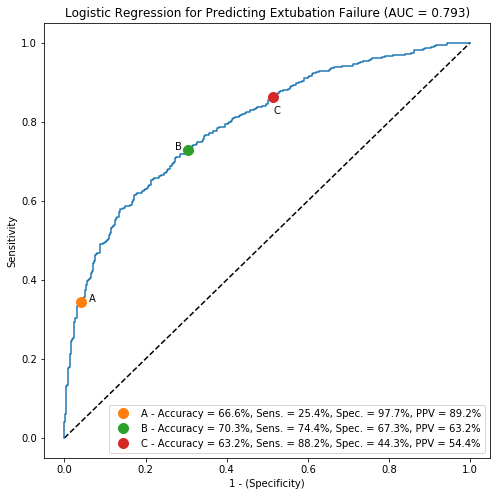

In [22]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.8, 0.35, 0.25
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_test, y_pred_lr[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_test, y_pred_lr[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_test, y_pred_lr[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr)
plt.plot(fpr_lr[A], tpr_lr[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
plt.annotate('A', (fpr_lr[A]+0.02, tpr_lr[A]))
plt.plot(fpr_lr[B], tpr_lr[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
plt.annotate('B', (fpr_lr[B]-0.03, tpr_lr[B]))
plt.plot(fpr_lr[C], tpr_lr[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
plt.annotate('C', (fpr_lr[C], tpr_lr[C]-0.04))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Logistic Regression for Predicting Extubation Failure (AUC = {:.3f})'.format(auc_lr))
plt.legend(loc='lower right')
plt.savefig('plots/lr.png', bbox_inches='tight')
plt.show()

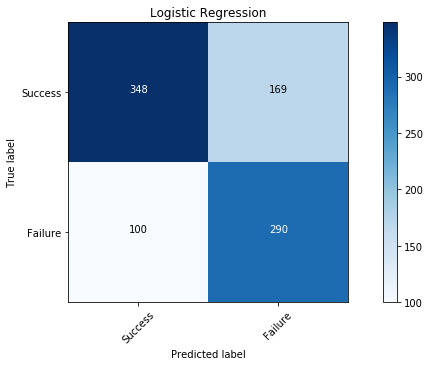

In [23]:
# Calculate the confusion matrix
decision_threshold = thresh_B
cm = confusion_matrix(y_test, y_pred_lr[:]>decision_threshold)
plot_confusion_matrix(cm, ['Success', 'Failure'], normalize=False, title='Logistic Regression')

In [24]:
# Create a function to calculate the SAPS II score given some input data
def rsbi(data):
    
    '''
    Function to calculate the RSBI for each patient
    
    INPUTS:
    data - array of shape (m,n,T), where m = number of patients and n = number of features, T = number of time steps
    
    OUTPUTS:
    rsbi - array of shape (m,1), with the calculated RSBI
    '''
    
    # Calculate RSBI
    freq = data[:,25,-1]
    tidvol = data[:,26,-1]/1000
    rsbi = freq/tidvol
    
    # Make prediction
    pred = rsbi > 100
    
    # Return results
    return rsbi, pred

In [25]:
# Load the data
_data = np.load('res/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_train']
y_train = _data['y_train']
X_val = _data['X_val']
y_val = _data['y_val']
X_test = _data['X_test']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [26]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 9065
No. of patients in train, val, test sets: 7252, 906, 907
No. of extubation failures in train, val, test sets: 2987, 383, 390
Proportion of extubation failures in train, val, test sets: 41.189%, 42.274%, 42.999%


In [27]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7252, 37, 24)
y_train: (7252,)
X_val: (906, 37, 24)
y_val: (906,)
X_test: (907, 37, 24)
y_test: (907,)


In [28]:
# Calculate RSBI and make prediction
rsbi, y_pred_rsbi = rsbi(X_test)

C:\Users\anear\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


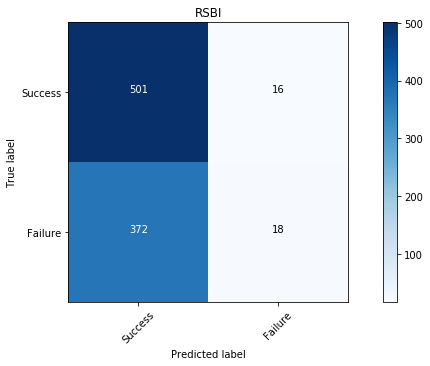

In [29]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rsbi)
plot_confusion_matrix(cm, ['Success', 'Failure'], normalize=False, title='RSBI')

In [30]:
# Calculate sensitivity and specificity for RSBI
[[tn_rsbi,fp_rsbi],[fn_rbsi,tp_rsbi]] = confusion_matrix(y_test, y_pred_rsbi)
tpr_rsbi = tp_rsbi / (tp_rsbi + fp_rsbi) # TPR = sensitivity
fpr_rsbi = tp_rsbi / (tp_rsbi + fp_rsbi) # FPR = specificity

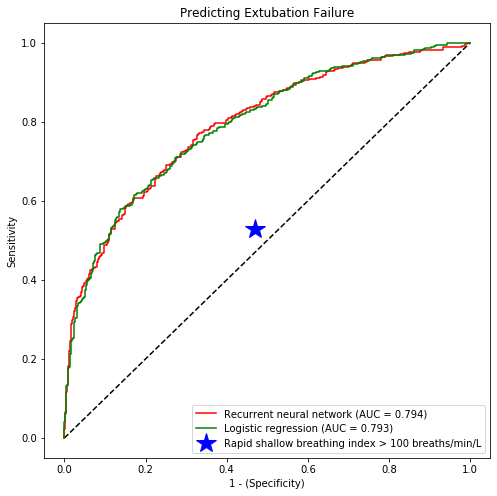

In [31]:
# Compare ROC curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn, label='Recurrent neural network (AUC = {:.3f})'.format(auc_rnn), c='red', ls='-')
plt.plot(fpr_lr, tpr_lr, label='Logistic regression (AUC = {:.3f})'.format(auc_lr), c='green', ls='-')
plt.plot(1-fpr_rsbi, tpr_rsbi, '*', markersize=20, c='blue', label='Rapid shallow breathing index > 100 breaths/min/L')
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Predicting Extubation Failure')
plt.legend(loc='lower right')
plt.savefig('plots/roc_curves.png', bbox_inches='tight')
plt.show()